# Stylometric experiments Goethe in *Frankfurter gelehrte Anzeigen*

In [1]:
import glob
import os
import shutil
import re
import unidecode
from itertools import product
import random

import numpy as np
RND = 12345
random.seed(RND)
np.random.seed(RND)

from scipy.spatial.distance import cdist, pdist
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestCentroid
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_curve

from distance_metrics import pairwise_minmax as minmax
from knn import KNN

from tqdm import tqdm
from inspect import signature

DIRTY = re.compile(r'\s*\-\+')

## Preprocessing

In [2]:
def load_folder(path=None, ext='.txt', size=None):
    texts = []
    for fn in glob.glob(path + '/*' + ext):
        with open(fn, 'r') as f:
            text = f.read().strip()
            text = ' '.join(text.split())
            text = text.replace('ſ', 's')
            text = re.sub(DIRTY, '', text)
            text = ''.join(c for c in text if c.isalpha() or c.isspace())
            text = ' '.join(text.split())
            text = unidecode.unidecode(text) # !!!!!!!
            title = os.path.basename(fn).lower().replace(ext, '')
            meta = title.split('_')
            author, *title = meta
            title = '_'.join(title) + '+' + author
            if size:
                cnt = 1
                si, ei = 0, size
                while ei < len(text):
                    texts.append([title + '_' + str(cnt), title, author, text[si:ei]])
                    # UPDATE:
                    si += size
                    ei += size
                    cnt += 1
            else:
                texts.append([title, title, author, text])
    texts = pd.DataFrame(texts, columns=('id', 'title', 'author', 'text'))
    texts = texts.set_index('id')
    return texts

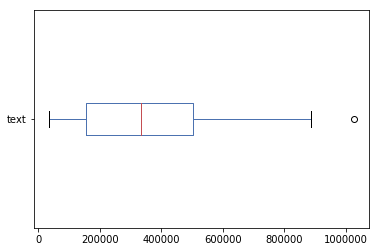

In [3]:
src = load_folder('data/source', size=None)
src.text.str.len().plot('box', vert=False)

### Target data (of unknown, to-verify authorship)

In [4]:
target = load_folder('data/target', size=None, ext='.txt')
target.head()

,title,author,text
id,,,
herder_05+fga,herder_05+fga,fga,Gottingen und Gema I D Michaclis Verfuch uber ...
unverified_clean_01+fga,unverified_clean_01+fga,fga,Danzig Cymbelline ein Trauerspiel nach einem v...
verified_clean_04+goethe,verified_clean_04+goethe,goethe,Nachrede statt der versprochenen Vorrede Die b...
herder_04+fga,herder_04+fga,fga,Helle D Fel xswleyi Psksplrrnlie Evangelii Joh...
herder_06+fga,herder_06+fga,fga,Leipzig dklnekktmgm ahek den Unterschied der S...


count       15.000000
mean      7106.866667
std       2867.641860
min       2102.000000
25%       5836.500000
50%       7468.000000
75%       8481.500000
max      12865.000000
Name: length, dtype: float64

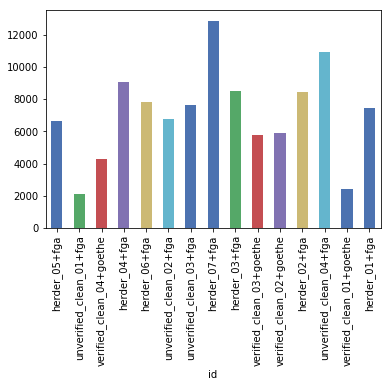

In [5]:
target['length'] = target.text.str.len()
target.length.plot('bar')
target.length.describe()

In [6]:
SIZE = int(target.length.min())
source = load_folder('data/source', ext='.txt', size=SIZE)
target = load_folder('data/target', ext='.txt', size=None)

In [7]:
source.head(20)

,title,author,text
id,,,
20-wmeisterlehrgoethe_s_werke-7+goethe_1,20-wmeisterlehrgoethe_s_werke-7+goethe,goethe,Erstes C a p i t e l Der Fruhling war in seine...
20-wmeisterlehrgoethe_s_werke-7+goethe_2,20-wmeisterlehrgoethe_s_werke-7+goethe,goethe,rlich sich davon Alechenschaft geben zu wollen...
20-wmeisterlehrgoethe_s_werke-7+goethe_3,20-wmeisterlehrgoethe_s_werke-7+goethe,goethe,ng bis an die Hauser hinan und kleine nutzbare...
20-wmeisterlehrgoethe_s_werke-7+goethe_4,20-wmeisterlehrgoethe_s_werke-7+goethe,goethe,und las Er schlen das Blatt einige mal durchge...
20-wmeisterlehrgoethe_s_werke-7+goethe_5,20-wmeisterlehrgoethe_s_werke-7+goethe,goethe,wohin fliehen Welt besser hatte der Geist mir ...
20-wmeisterlehrgoethe_s_werke-7+goethe_6,20-wmeisterlehrgoethe_s_werke-7+goethe,goethe,en Teich los Wilhelm eilte ihm nach aber zu sp...
20-wmeisterlehrgoethe_s_werke-7+goethe_7,20-wmeisterlehrgoethe_s_werke-7+goethe,goethe,ch dasteht wer selbst so viel als moglich an d...
20-wmeisterlehrgoethe_s_werke-7+goethe_8,20-wmeisterlehrgoethe_s_werke-7+goethe,goethe,gleich fur seinen alten Gonner Iaeno erlonnte ...
20-wmeisterlehrgoethe_s_werke-7+goethe_9,20-wmeisterlehrgoethe_s_werke-7+goethe,goethe,onderbar Der Abbe trat aus dem Zimmer winkte I...


In [8]:
target.head()

,title,author,text
id,,,
herder_05+fga,herder_05+fga,fga,Gottingen und Gema I D Michaclis Verfuch uber ...
unverified_clean_01+fga,unverified_clean_01+fga,fga,Danzig Cymbelline ein Trauerspiel nach einem v...
verified_clean_04+goethe,verified_clean_04+goethe,goethe,Nachrede statt der versprochenen Vorrede Die b...
herder_04+fga,herder_04+fga,fga,Helle D Fel xswleyi Psksplrrnlie Evangelii Joh...
herder_06+fga,herder_06+fga,fga,Leipzig dklnekktmgm ahek den Unterschied der S...


In [9]:
source.groupby('author')['title'].value_counts().head()

author  title                                                          
goethe  19-wmeisterlehrgoethe_s_werke-7+goethe                             487
        43-nachgelassene-goethe_s_werke-29+goethe                          421
        45-nachgelassene-goethe_s_werke-29+goethe                          410
        39-verschiedenes-kleine-sprosa-idyllen-goethe_s_werke-27+goethe    409
        35-cellini-usw-goethe_s_werke-15+goethe                            408
Name: title, dtype: int64

In [10]:
len(source)

12492

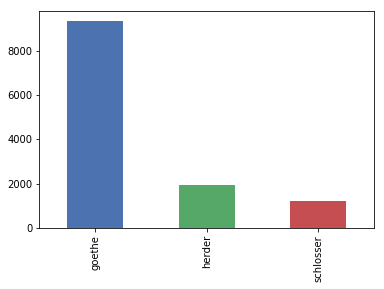

In [11]:
source.author.value_counts().plot('bar');

In [12]:
unique_src = source.groupby(['title','author']).size().reset_index()
x = unique_src['title']
y = unique_src['author']

In [13]:
train_titles, dev_titles, train_authors, dev_authors = train_test_split(x, y,
                                                                        test_size=.25,
                                                                        stratify=y,
                                                                        random_state=42)
print(train_titles.shape, train_authors.shape)
print(dev_titles.shape, dev_authors.shape)

(52,) (52,)
(18,) (18,)


In [14]:
train = source[source['title'].isin(train_titles)]
dev = source[source['title'].isin(dev_titles)]
print(train.shape)
print(dev.shape)

(9622, 3)
(2870, 3)


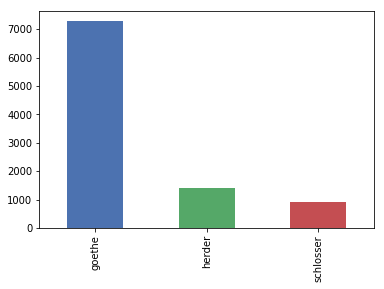

In [15]:
train['author'].value_counts().plot('bar');

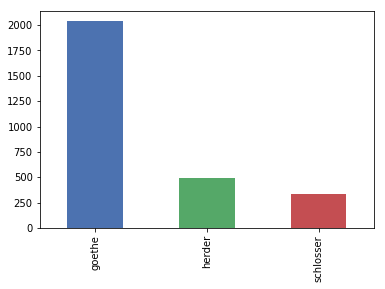

In [16]:
dev['author'].value_counts().plot('bar');

# Restrict Goethe samples

### Vectorization

In [17]:
# set vectorization params:
p_char = {'use_idf': True,
     'max_features': 10000,
     'analyzer': 'char',
     'min_df': 2,
     'lowercase': True,
     'norm': 'l1',
     'ngram_range': (4, 4)}

p_word = {'use_idf': True,
     'max_features': 50000,
     'analyzer': 'word',
     'min_df': 2,
     'lowercase': True,
     'norm': 'l1',
     'ngram_range': (1, 2)}

We wrap this in a single fucntion:

In [18]:
def downsample_goethe(df):
    goethe_samples = df[df['author'] == 'goethe']
    non_goethe_samples = df[df['author'] != 'goethe']
    
    vectorizer = TfidfVectorizer(**p_char)
    non_goethe_X = vectorizer.fit_transform(non_goethe_samples.text).toarray()
    goethe_X = vectorizer.transform(goethe_samples.text).toarray()
    
    scaler = StandardScaler()
    non_goethe_X = scaler.fit_transform(non_goethe_X)
    goethe_X = scaler.transform(goethe_X)
    
    centroid = np.mean(non_goethe_X, axis=0)
    dists = cdist(goethe_X, [centroid], 'cosine').ravel()
    
    nn_idxs = dists.argsort()[:len(non_goethe_samples)]
    restricted_goethe_samples = goethe_samples.iloc[nn_idxs, :]
    
    return pd.concat((restricted_goethe_samples, non_goethe_samples))

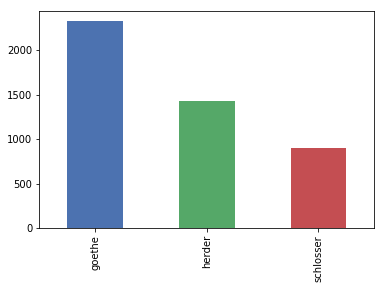

In [19]:
train = downsample_goethe(train)
train.author.value_counts().plot('bar');

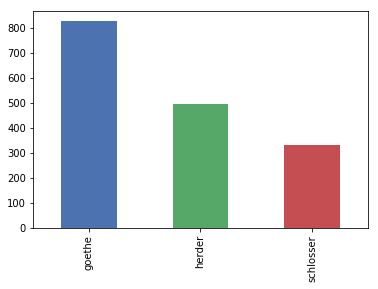

In [20]:
dev = downsample_goethe(dev)
dev.author.value_counts().plot('bar');

In [21]:
encoder = LabelEncoder()
train_y = encoder.fit_transform(train.author)
dev_y = encoder.transform(dev.author)

In [22]:
vectorizer = TfidfVectorizer(**p_char)
train_X = vectorizer.fit_transform(train.text).toarray()
dev_X = vectorizer.transform(dev.text).toarray()

In [23]:
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
dev_X = scaler.transform(dev_X)

In [24]:
print(train_X.shape, train_y.shape)
print(dev_X.shape, dev_y.shape)

(4660, 10000) (4660,)
(1658, 10000) (1658,)


## Attribution

Simple feature dropout:

In [38]:
def feature_dropout(X1, X2, p=.5):
    n = X1.shape[1]
    idxs = np.random.choice(n, int(n * p), replace=False)
    return X1[:, idxs], X2[:, idxs]

In [39]:
def instance_dropout(X, y, n=30):
    nb = X.shape[0]
    idxs = np.random.choice(nb, n, replace=False)
    return X[idxs, :], y[idxs]

In [40]:
METRICS = {'cosine': 'cosine',
           'minmax': minmax}

In [41]:
class Attributor(object):
    def __init__(self, iters=100, base='profile',
                 rnd_prop=.5, random_state=1066,
                 num_instances=30, metric='cosine',
                 rnd_state=1234):
        assert base in ('profile', 'instance')
        assert metric in METRICS
        assert (rnd_prop >= 0.0) and (rnd_prop <= 1.0)
        
        np.random.seed(rnd_state)
        self.metric = METRICS[metric]
        self.iters = iters
        self.base = base
        self.rnd_prop = rnd_prop
        self.num_instances = num_instances
    
    def fit(self, X, y):
        if self.base == 'profile':
            self.train_X = NearestCentroid().fit(X, y).centroids_
            self.train_y = np.array(range(self.train_X.shape[0]))
            
        elif self.base == 'instance':
            self.train_X = X.copy()
            self.train_y = y.copy()
        
        self.num_classes_ = len(set(y))
    
    def predict(self, X, target=-1):
        preds = self.predict_proba(X, target=target)
        return np.argmax(preds, axis=1)
    
    def predict_proba(self, X, target=-1):
        nb = X.shape[0]
        probas = np.zeros((nb, self.num_classes_))
        
        if target > -1:
            targets = self.train_y == target
            target_X = self.train_X[targets]
            target_y = self.train_y[targets]
            
            non_targets = self.train_y != target
            non_target_X = self.train_X[non_targets]
            non_target_y = self.train_y[non_targets]
            
        for it in range(self.iters):
            if it and (it % 25) == 0:
                print(f'-> iter {it}')
                
            if target > -1:
                # sample instances
                selected_X, selected_y = instance_dropout(non_target_X, non_target_y,
                                                   n=self.num_instances)
                target_X_, target_y_ = instance_dropout(target_X, target_y,
                                                   n=self.num_instances)
                
                train_X_ = np.vstack((target_X_, selected_X))
                train_y_ = np.hstack((target_y_, selected_y))
            else:
                train_X_ = self.train_X
                train_y_ = self.train_y
            
            # apply feature dropout:
            if self.rnd_prop < 1.0:
                train_X_, X_ = feature_dropout(train_X_, X, p=self.rnd_prop)
            else:
                train_X_, X_ = train_X_, X
            
            # fit simple knn:
            knn = KNN(k=1, metric=self.metric)
            knn.fit(train_X_, train_y_)
            pred = np.array(knn.predict(X_))
            probas[np.arange(nb), pred] += 1
            
        probas = normalize(probas, norm='l1')    
        return probas

Simple attribution on dev set: no dropout, no imposters:

In [42]:
attributor = Attributor(iters=1, base='instance',
                        rnd_prop=1.)
attributor.fit(train_X, train_y)
preds = attributor.predict(dev_X)

import sklearn.metrics as metrics
print(f'Accuracy: {metrics.accuracy_score(preds, dev_y)}')
print(f'F1-score: {metrics.f1_score(preds, dev_y, average="macro")}')

Accuracy: 0.8003618817852834
F1-score: 0.785480117367746


In [67]:
attributor = Attributor(iters=250, base='instance',
                        rnd_prop=.5)
attributor.fit(train_X, train_y)
preds = attributor.predict(dev_X, target=-1)
print(f'Accuracy: {metrics.accuracy_score(preds, dev_y)}')
print(f'F1-score: {metrics.f1_score(preds, dev_y, average="macro")}')

-> iter 25
-> iter 50
-> iter 75
-> iter 100
-> iter 125
-> iter 150
-> iter 175
-> iter 200
-> iter 225
Accuracy: 0.8293124246079614
F1-score: 0.8106777494901376


In [68]:
attributor = Attributor(iters=250, base='instance',
                    rnd_prop=.5, num_instances=100)
attributor.fit(train_X, train_y)

target_idx = list(encoder.classes_).index('goethe')
preds = attributor.predict(dev_X, target=target_idx)

print(f'Accuracy: {metrics.accuracy_score(preds, dev_y)}')
print(f'F1-score: {metrics.f1_score(preds, dev_y, average="macro")}')

-> iter 25
-> iter 50
-> iter 75
-> iter 100
-> iter 125
-> iter 150
-> iter 175
-> iter 200
-> iter 225
Accuracy: 0.9125452352231604
F1-score: 0.9022062058056705


In [69]:
def plot_confusion_matrix(cm, target_names,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.tick_params(labelsize=6)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=90)
    plt.yticks(tick_marks, target_names)
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.plot()

/Users/mikekestemont/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/mikekestemont/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


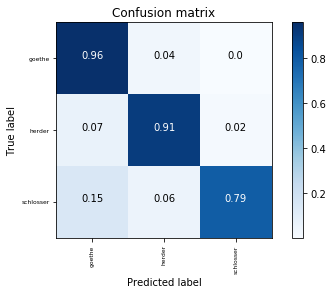

In [70]:
T = encoder.inverse_transform(dev_y)
P = encoder.inverse_transform(preds)
cm = confusion_matrix(T, P, labels=encoder.classes_)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plot_confusion_matrix(cm_normalized, target_names=encoder.classes_)

## Test data

In [71]:
def heat(test_probas, candidates, titles):
    fig = plt.figure(figsize=(10, 20))
    plt.imshow(test_probas, interpolation='nearest', cmap=plt.cm.Reds,
              aspect='auto')
    plt.tick_params(labelsize=6)
    plt.title('Verification probabilities')
    plt.colorbar()
    tick_marks = np.arange(len(candidates))
    plt.xticks(tick_marks, candidates, rotation=90, fontsize=14)
    tick_marks = np.arange(len(titles))
    plt.yticks(tick_marks, titles, fontsize=14)
    thresh = test_probas.max() / 2.
    for i, j in product(range(test_probas.shape[0]), range(test_probas.shape[1])):
        plt.text(j, i, round(test_probas[i, j], 2),
                 horizontalalignment="center",
                 color="white" if test_probas[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Title')
    plt.xlabel('Candidate')
    plt.plot()

In [72]:
test_X = vectorizer.transform(target.text).toarray()
test_X = scaler.transform(test_X)

-> iter 25
-> iter 50
-> iter 75
-> iter 100
-> iter 125
-> iter 150
-> iter 175
-> iter 200
-> iter 225
(15, 2)


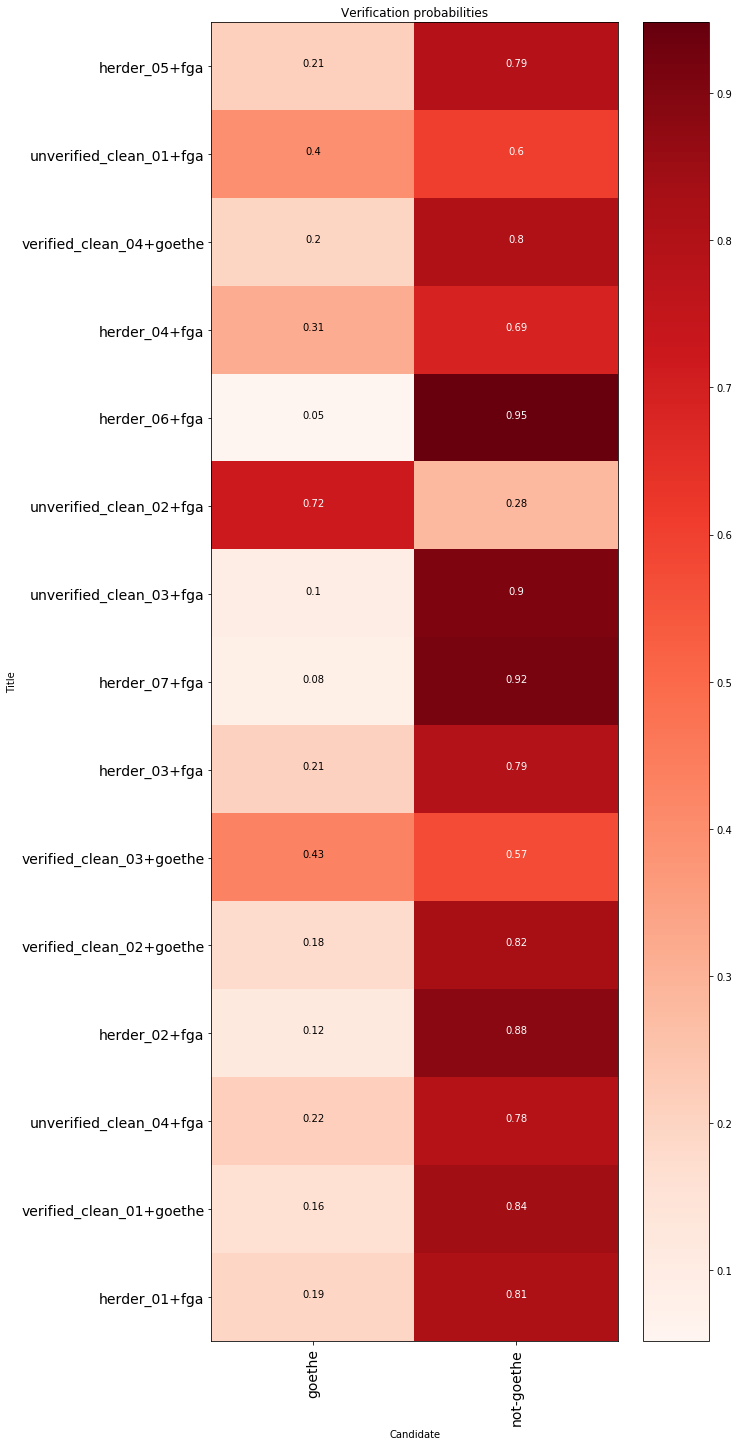

In [73]:
attributor = Attributor(iters=250, base='instance',
                        rnd_prop=.5, num_instances=100)
attributor.fit(train_X, train_y)
test_probas = attributor.predict_proba(test_X, target=target_idx)
final = np.zeros((test_probas.shape[0], 2))
final[:, 0] = test_probas[:, 0]
final[:, 1] = test_probas[:, 1] + test_probas[:, 2]
print(final.shape)
heat(final, ['goethe', 'not-goethe'], target.title)

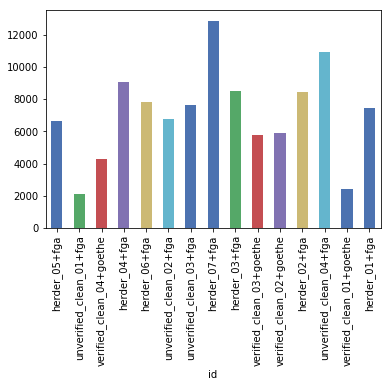

In [74]:
target['length'] = target.text.str.len()
target.length.plot('bar')

## Craig's Zeta

In [75]:
from sklearn.feature_extraction.text import CountVectorizer

# set vectorization params:
zeta_p = {'binary': True,
          'max_features': 10000,
          'analyzer': 'word',
          'min_df': 2}

T = tuple(train.text[train.author == 'goethe'])
C = tuple(train.text[train.author != 'goethe'])
zeta_vec = CountVectorizer(**zeta_p).fit(T + C)
T = zeta_vec.transform(T).toarray()
C = zeta_vec.transform(C).toarray()

In [76]:
n_T = T.shape[0]
n_C = C.shape[0]
print(f'Number of Goethe: {n_T}')
print(f'Number of others: {n_C}')

Number of Goethe: 2330
Number of others: 2330


In [77]:
dp_T = T.sum(axis=0) / n_T
dp_C = C.sum(axis=0) / n_C

In [78]:
Z = dp_T - dp_C

In [79]:
zeta_vocab = zeta_vec.get_feature_names()
ranked = [(zeta_vocab[idx], Z[idx]) for idx in np.argsort(Z)]

In [80]:
print('-> words under-used by Goethe:')
for i in range(25):
    w, s = ranked[i]
    print(f'   {w} {s:{0}.{3}}')

print('=' * 20)

print('-> words over-used by Goethe:')
for i in range(25):
    w, s = ranked[-i-1]
    print(f'   {w} {s:{0}.{3}}')

-> words under-used by Goethe:
   also -0.315
   oder -0.301
   bey -0.222
   hat -0.213
   ge -0.207
   dies -0.207
   kann -0.192
   menschen -0.189
   blos -0.173
   alle -0.17
   kein -0.169
   anders -0.146
   sei -0.145
   muss -0.144
   seele -0.143
   andre -0.143
   wenn -0.137
   ihrer -0.134
   haben -0.133
   sondern -0.13
   wer -0.13
   unsrer -0.129
   ihnen -0.127
   mensch -0.123
   dunkt -0.121
-> words over-used by Goethe:
   bei 0.283
   mir 0.241
   indem 0.189
   sey 0.188
   mich 0.163
   schon 0.158
   besonders 0.156
   hier 0.149
   wieder 0.146
   doch 0.145
   sich 0.133
   nun 0.131
   war 0.125
   wir 0.122
   sah 0.121
   welche 0.121
   vor 0.115
   meine 0.111
   sehen 0.11
   man 0.109
   seite 0.106
   sogleich 0.102
   jedoch 0.102
   farben 0.101
   an 0.1


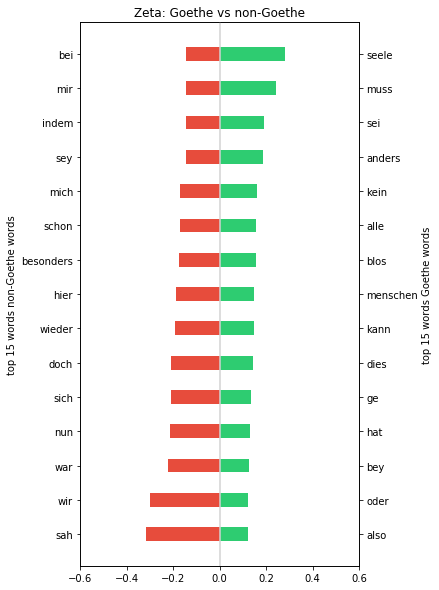

In [81]:
width = .4
m = 15
fig = plt.figure(figsize=(5, 10))

goe_labels, goe_scores = zip(*ranked[:m])
non_labels, non_scores = zip(*ranked[-m:])
pos = np.arange(m) - (width / 2)

ax1 = fig.add_subplot(111)
plt.barh(pos, goe_scores, width, label='Goethe', color="#e74c3c")

plt.yticks(pos, non_labels)
ax1.set_ylabel(f'top {m} words non-Goethe words')

ax2 = ax1.twinx()
ax2.barh(pos, non_scores, width, label='non-Goethe', color='#2ecc71')
ax2.set_yticks(pos)
ax2.set_yticklabels(goe_labels)

plt.xlim((-.6, +.6))
plt.axvline(0, color='lightgrey')
ax2.set_ylabel(f'top {m} words Goethe words')
plt.xlabel('Zeta scores')
plt.title(f'Zeta: Goethe vs non-Goethe');

## Verification

## Creation of imposter samples

In [25]:
samples = []
outdir = 'data/verification/imposter_samples'

try:
    shutil.rmtree(outdir)
except FileNotFoundError:
    pass
os.mkdir(outdir)

In [26]:
cnt = 1
for fn in glob.glob('data/verification/FgA-impostor-corpus/*.txt'):
    print(fn)
    with open(fn) as f:
        lines = f.readlines()
    f = open(outdir + '/' + str(cnt) + '.txt', 'w')
    for idx, line in enumerate(lines):
        if idx >= 2 and idx <= len(lines):
            if lines[idx - 1] == '\n' and lines[idx - 2].endswith('\n'):
                if line.replace('-', '').strip().endswith('.') and line.lstrip()[0].isupper() and line.count('.') == 1:
                    if lines[idx + 1] == '\n':
                        f.close()
                        cnt += 1
                        f = open(outdir + '/' + str(cnt) + '.txt', 'w')
        f.write(line + '\n')
f.close()

data/verification/FgA-impostor-corpus/FgA1779-OCR.txt.txt
data/verification/FgA-impostor-corpus/FgA1786-OCR.txt
data/verification/FgA-impostor-corpus/FgA1785-OCR.txt
data/verification/FgA-impostor-corpus/FgA1776-OCR.txt.txt
data/verification/FgA-impostor-corpus/FgA1784-OCR.txt
data/verification/FgA-impostor-corpus/FgA1781-OCR.txt
data/verification/FgA-impostor-corpus/FgA1775-OCR.txt
data/verification/FgA-impostor-corpus/FgA1774-OCR.txt
data/verification/FgA-impostor-corpus/FgA1782-OCR.txt
data/verification/FgA-impostor-corpus/FgA1783-OCR.txt
data/verification/FgA-impostor-corpus/FgA1777-OCR.txt.txt


In [27]:
imposter_texts = []
for fn in glob.glob('data/verification/imposter_samples/*.txt'):
    with open(fn) as f:
        text = f.read()
        text = ' '.join(text.split())
        text = text.replace('ſ', 's')
        text = re.sub(DIRTY, '', text)
        text = ''.join(c for c in text if c.isalpha() or c.isspace())
        text = ' '.join(text.split())
        text = unidecode.unidecode(text) # !!!!!!!
    if len(text) >= 2102:
        imposter_texts.append(text)
print(len(imposter_texts))

2282


In [28]:
class Verifier():
    def __init__(self, iters=100, 
                 rnd_prop=.5, random_state=1066,
                 num_instances=30, metric='cosine',
                 rnd_state=1234):
        assert (rnd_prop >= 0.0) and (rnd_prop <= 1.0)
        
        np.random.seed(rnd_state)
        self.iters = iters
        self.rnd_prop = rnd_prop
        self.num_instances = num_instances
    
    def predict_proba(self, target, source_X, imposter_X):
        """
        target = (single) anonymous text
        source_X = candidate author
        imposter_X = imposter documents
        """
        total_features = imposter_X.shape[1]
        total_imposters = imposter_X.shape[0]
        total_source = source_X.shape[0]
        target = np.array([target])
        hits = np.zeros(self.iters)
            
        for it in range(self.iters):
            imposters_ = imposter_X[np.random.choice(total_imposters, self.num_instances, replace=False), :]
            source_ = source_X[np.random.choice(total_source, self.num_instances, replace=False), :]
            
            if self.rnd_prop < 1.0:
                idxs = np.random.choice(total_features, int(total_features * self.rnd_prop), replace=False)
                imposters_ = imposters_[:, idxs]
                source_ = source_[:, idxs]
                target_ = target[:, idxs]
            
            min_imp_dist = np.min(cdist(target_, imposters_, metric='cosine'))
            min_src_dist = np.min(cdist(target_, source_, metric='cosine'))
            
            if min_src_dist < min_imp_dist:
                hits[it] = 1
        
        return np.mean(hits)
            

In [29]:
candidate = 'goethe'
source = train_X[train['author'] == candidate]
targets = dev_X

In [30]:
target_y = np.array([1 if a == candidate else 0 for a in dev['author']])

In [31]:
imposters = scaler.transform(vectorizer.transform(imposter_texts).toarray())
print(imposters.shape)

(2282, 10000)


In [32]:
verifier = Verifier(iters=25, num_instances=25)
probas = [verifier.predict_proba(target=t, source_X=source,
                       imposter_X=imposters) for t in tqdm(targets)]

100%|██████████| 1658/1658 [01:59<00:00, 13.89it/s]


In [33]:
precision, recall, thresholds = precision_recall_curve(target_y, probas)

In [34]:
f1s = [f1_score(target_y, (probas > th) * 1) for th in thresholds]

/Users/mikekestemont/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [35]:
max_idx = np.array(f1s).argmax()
max_f1 = f1s[max_idx]
max_th = thresholds[max_idx]
print(max_f1, max_th)

0.7803278688524592 0.36


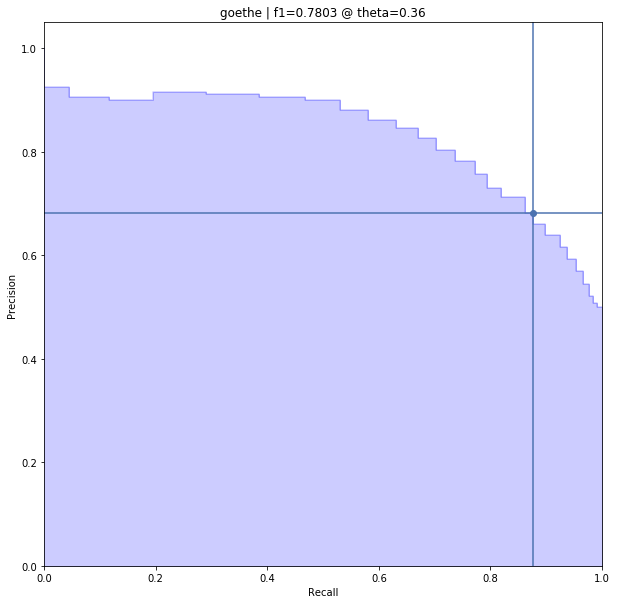

In [36]:
plt.figure(figsize=(10, 10))
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.plot(recall[max_idx], precision[max_idx], 'o')
plt.axhline(precision[max_idx])
plt.axvline(recall[max_idx])
plt.title(f'{candidate} | f1={round(max_f1, 4)} @ theta={round(max_th, 4)}');

## Unseen data

In [37]:
target = load_folder('data/target', ext='.txt', size=None)
target_X = scaler.transform(vectorizer.transform(target['text']).toarray())
print(target_X.shape)

(15, 10000)


In [38]:
source = train_X[train['author'] == 'goethe']

In [39]:
verifier = Verifier(iters=25, num_instances=25)
target['proba'] = [verifier.predict_proba(target=t, source_X=source,
                       imposter_X=imposters) for t in tqdm(target_X)]

100%|██████████| 15/15 [00:01<00:00, 13.67it/s]


In [40]:
certified = target[target['author'] == 'goethe']
relaxed = certified['proba'].mean()

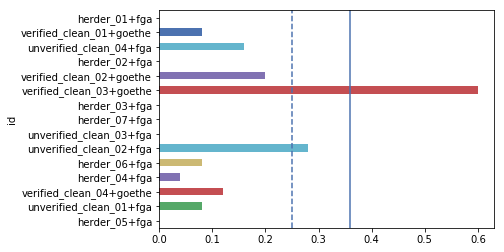

In [41]:
ax = target['proba'].plot('barh')
ax.axvline(max_th, ls='-')
ax.axvline(relaxed, ls='--')

## Fishing Goethe

In [42]:
samples = []
outdir = 'data/verification/fga_samples'

try:
    shutil.rmtree(outdir)
except FileNotFoundError:
    pass
os.mkdir(outdir)

In [43]:
cnt = 1
for fn in glob.glob('data/verification/FgA-1772-1773/*.txt'):
    print(fn)
    with open(fn) as f:
        lines = f.readlines()
    f = open(outdir + '/' + str(cnt) + '.txt', 'w')
    for idx, line in enumerate(lines):
        if idx >= 2 and idx <= len(lines):
            if lines[idx - 1] == '\n' and lines[idx - 2].endswith('\n'):
                if line.replace('-', '').strip().endswith('.') and line.lstrip()[0].isupper() and line.count('.') == 1:
                    if lines[idx + 1] == '\n':
                        f.close()
                        cnt += 1
                        f = open(outdir + '/' + os.path.basename(fn).replace('.txt', '') + str(cnt) + '.txt', 'w')
        f.write(line + '\n')
f.close()

data/verification/FgA-1772-1773/FgA1773-OCR.txt
data/verification/FgA-1772-1773/FgA1772OCR.txt


In [44]:
verification_titles, verification_texts = [], []
for fn in glob.glob('data/verification/fga_samples/*.txt'):
    with open(fn) as f:
        text = f.read()
        text = ' '.join(text.split())
        text = text.replace('ſ', 's')
        text = re.sub(DIRTY, '', text)
        text = ''.join(c for c in text if c.isalpha() or c.isspace())
        text = ' '.join(text.split())
        text = unidecode.unidecode(text) # !!!!!!!
    if len(text) >= 2102:
        verification_texts.append(text)
        verification_titles.append(os.path.basename(fn))
print(len(verification_texts))

348


In [45]:
verification_X = scaler.transform(vectorizer.transform(verification_texts).toarray())

In [46]:
verifier = Verifier(iters=10, num_instances=10)
probas = [verifier.predict_proba(target=t, source_X=source,
                       imposter_X=imposters) for t in tqdm(verification_X)]

100%|██████████| 348/348 [00:04<00:00, 76.61it/s]


In [47]:
results = pd.DataFrame(list(zip(verification_titles, probas)), columns=('%%filename', 'probability'))

In [48]:
results = results.sort_values(by=['probability'], ascending=False)

In [49]:
results

,%%filename,probability
253,FgA1772OCR415.txt,0.6
72,FgA1773-OCR223.txt,0.5
98,FgA1772OCR419.txt,0.4
234,FgA1772OCR402.txt,0.4
69,FgA1773-OCR209.txt,0.4
9,FgA1772OCR484.txt,0.4
206,FgA1772OCR559.txt,0.3
78,FgA1773-OCR155.txt,0.3
264,FgA1773-OCR260.txt,0.3
220,FgA1772OCR611.txt,0.3
